In [87]:
import pandas as pd
import torch
import json
import os
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import f1_score,accuracy_score,recall_score
import traceback



import warnings
warnings.filterwarnings('ignore')

In [88]:
from aif360.sklearn import metrics
from sklearn.metrics import confusion_matrix

In [89]:
namedic2 = {}
namedic2['egr_pred'] = 'EGR'
namedic2['gsr_pred'] = 'GSR'
namedic2['private_pred'] = 'PRIV'
def algnames(name):
    return namedic2[name]

In [90]:
# Try with Adult First

In [91]:
paths  = ['data/datasets/publiccov_ca/', 'data/datasets/employment_ca/', 'data/datasets/law_school/', 'data/datasets/diabetes/']

dnames = {'publiccov_ca': 'Public Coverage',
          'employment_ca': 'Employment',
          'law_school': 'Law School Admissions',
          'diabetes': 'Diabetes'
         }
cnames = [['AGEP', 'SCHL', 'MAR', 'SEX', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'PINCP', 'ESR', 'FER', 'RAC1P',
       'PUBCOV'],
          ['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR'],
          ['zfygpa', 'zgpa', 'DOB_yr', 'weighted_lsat_ugpa', 'cluster_tier',
       'family_income', 'lsat', 'ugpa', 'isPartTime', 'sex', 'race',
       'pass_bar'],
          ['race', 'sex', 'age', 'admissiontypeid', 'dischargedispositionid',
       'admissionsourceid', 'timeinhospital', 'numlabprocedures',
       'numprocedures', 'nummedications', 'numberoutpatient',
       'numberemergency', 'numberinpatient', 'diag1', 'diag2', 'diag3',
       'numberdiagnoses', 'maxgluserum', 'A1Cresult', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed', 'readmitted']
]

In [92]:
list1 = ['baseline_pred','randomforest_pred']
    
list2 = ['adv_rew_pred',
             'adv_deb_pred',
             'lfr_pred',
             'caleq_pred',
             'rocv_pred',
             'egr_pred',
             'gsr_pred']
    
list3 = ['Softweights_pred','private_pred', 'DRO_pred']
    
list4 = ['ARL_pred', 'OG_DRO_pred']

In [93]:
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

In [94]:
def getresultsdic(path,cols):
    
    results_df = pd.read_csv(path+'test.csv',header=None)
    results_df.columns = cols
    results_df['ground_truth'] = pd.Categorical(results_df[cols[-1]]).codes
    results_df.drop(cols[-1],axis=1,inplace=True)
    
    results = {}
    ground_truth = results_df['ground_truth']
    patt = ""
    
    if 'sex' in results_df.columns:
        patt = 'sex'
    else:
        patt = 'SEX'
    ground_truth.index = results_df[patt]
    
    for file in os.listdir(path+'preds/'):
        # check only text files
        preds = None
        cname = file.split('.')[0]
        alg = cname.split('_pred')[0]+'_pred'
        hyp = file.split('_')[-1].split('.json')[0]
        
        if alg in list(namedic2.keys()) and is_float(hyp) and ('exp' in file or 'violation' in file):

            if file.endswith('.json'):
                f = open(path+'preds/'+file)
                items = json.load(f)
                f.close()
                preds=items
            if file.endswith('.pt') and 'model' not in file:
                items = torch.load(path+'preds/'+file)
                cname = file.split('.')[0]
                preds=[int(i) for i in items.flatten().cpu().numpy()]

            if 'Accuracy' not in results:
                results['Accuracy'] = {}
            out_pred = pd.Series(preds)
            out_pred.index = results_df[patt]
            
            if alg not in results['Accuracy']:
                results['Accuracy'][alg] = {}
                
            if hyp not in results['Accuracy'][alg]:
                results['Accuracy'][alg][hyp] = []
                
            results['Accuracy'][alg][hyp].append(accuracy_score(list(ground_truth), list(out_pred)))

            if 'Equal Odds Difference' not in results:
                results['Equal Odds Difference'] = {}
                
            if alg not in results['Equal Odds Difference']:
                results['Equal Odds Difference'][alg] = {}
                
            if hyp not in results['Equal Odds Difference'][alg]:
                results['Equal Odds Difference'][alg][hyp] = []
                
            results['Equal Odds Difference'][alg][hyp].append(metrics.average_odds_difference(ground_truth,out_pred,prot_attr=patt, priv_group = 'Male', pos_label = 1))

        
    return results


# 2 line plots per metric - synthetic
# histograms for case studies 

def get_df(results):

    DF_list = []

    for metric in results:
        algset = {}
        for alg in results[metric]:
            for hyp in results[metric][alg]:
                for val in results[metric][alg][hyp]:
                    entry = {}
                    entry['metric'] = metric
                    entry['algorithm'] = algnames(alg.split('_pred')[0]+'_pred')
                    entry['hyp'] = hyp
                    entry['value'] = val

                    DF_list.append(entry)

    resultsdf = pd.DataFrame(DF_list)
        
    return resultsdf


In [95]:
def task(path,cols):
    results = getresultsdic(path,cols)
    df_temps = get_df(results)
    df_temps.sort_values(by="algorithm", inplace = True)
    df_temps['dataset'] = dnames[path.split('/')[-2]]
    return results,df_temps

In [96]:
dfs = []
for path,cols in zip(paths,cnames):
    results,df_temps = task(path,cols)
#     print(path)
#     print(results)
    dfs.append(df_temps)

In [97]:
dfs[3]

,metric,algorithm,hyp,value,dataset
247,Equal Odds Difference,EGR,0.05,-0.006763,Diabetes
249,Equal Odds Difference,EGR,0.05,-0.006763,Diabetes
73,Accuracy,EGR,0.2,0.624930,Diabetes
72,Accuracy,EGR,0.2,0.624930,Diabetes
71,Accuracy,EGR,0.2,0.624930,Diabetes
...,...,...,...,...,...
128,Accuracy,PRIV,0,0.620456,Diabetes
127,Accuracy,PRIV,0,0.616191,Diabetes
126,Accuracy,PRIV,0,0.621365,Diabetes
136,Accuracy,PRIV,1,0.625909,Diabetes


In [98]:
def doplots(alg, metric,color):
    
    sh = None
    alphs = None
    minacc = None
    maxacc = None
    
    alphs1 = ['(a)', '(b)', '(c)', '(d)']
    alphs2 = ['(e)', '(f)', '(g)', '(h)']
    
    if metric == 'Accuracy':
        sh = 'Acc'
        alphs = alphs1
        minacc = 0.1
        maxacc = 0.9
    elif metric == 'Equal Odds Difference':
        sh = 'EOD'
        alphs = alphs2
        minacc = -0.15
        maxacc = 0.15


    mpl.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams["font.family"] = 'DejaVu Serif'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 1
    plt.rcParams['grid.color'] = "#cccccc"
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42

    import matplotlib.ticker as ticker

    titles = ['Public Coverage', 'Employment', 'Law School Admission', 'Diabetes']
    
    


    for tdf,title,alph in zip(dfs[:1],titles[:1],alphs[:1]):
        
        df = tdf[tdf['metric']==metric]

        ax = sns.violinplot(data=df[df['algorithm']==alg], x="hyp", y="value", dodge=False, cut = 0, color = color)
        plt.title(title,fontsize=18,weight='bold')
        plt.xlabel(alph,fontsize=18,fontweight='bold')
        plt.ylabel(metric,fontsize=18,fontweight='bold')

        plt.xticks(rotation = 90, weight='bold')
        plt.yticks(ticks=None, labels=None)


        ax.xaxis.grid(True,which='both')
        ax.yaxis.grid(True,which='both')
        ax.set_axisbelow(True)
        ax.set_ylim([minacc, maxacc])



        ax.set_facecolor('white')
        ax.tick_params(axis='y', which='both',labelsize=16)
        ax.tick_params(axis='x', which='both',labelsize=16)

        plt.gca().yaxis.set_major_formatter(ScalarFormatter())

        plt.savefig('Plots3/Stability_'+sh+'_'+alg+'_'+title+'.pdf', pad_inches = 0,bbox_inches = "tight")
        plt.show()


    for tdf,title,alph in zip(dfs[1:],titles[1:],alphs[1:]):
        
        df = tdf[tdf['metric']==metric]

        ax = sns.violinplot(data=df[df['algorithm']==alg], x="hyp", y="value", dodge=False, cut = 0, color = color)
        plt.title(title,fontsize=18,weight='bold')
        plt.xlabel(alph,fontsize=18,fontweight='bold')
        plt.ylabel(None)
        plt.xticks(rotation = 90, weight='bold')
        plt.yticks(ticks=None, labels=None)
        ax.set_ylim([minacc, maxacc])

        ax.xaxis.grid(True,which='both')
        ax.yaxis.grid(True,which='both')
        ax.set_axisbelow(True)

        ax.set_facecolor('white')
        ax.tick_params(axis='y', which='both',labelsize=16)
        ax.tick_params(axis='x', which='both',labelsize=16)

        plt.gca().yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_ticklabels([])
        ax.yaxis.set_ticks_position('none')


        plt.savefig('Plots3/Stability_'+sh+'_'+alg+'_'+title+'.pdf', pad_inches = 0,bbox_inches = "tight")
        plt.show()

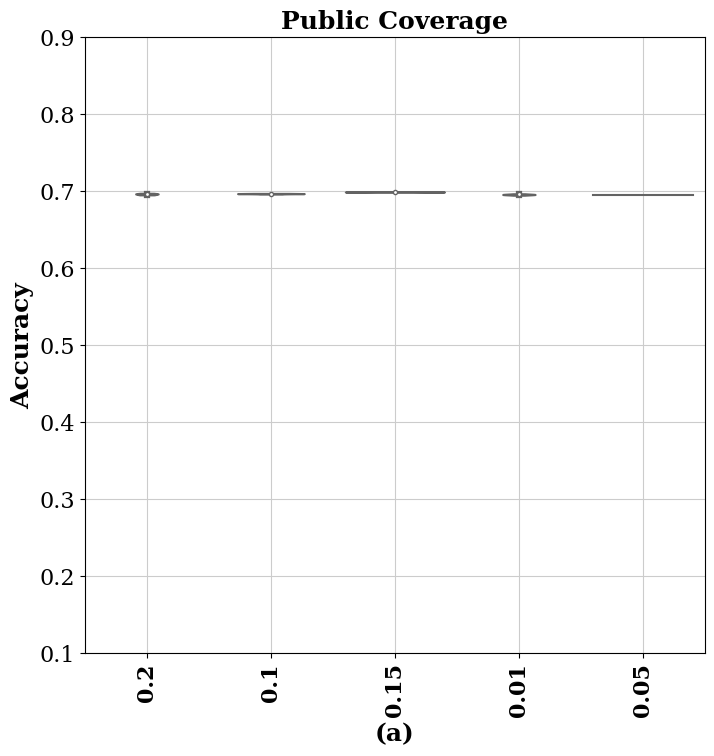

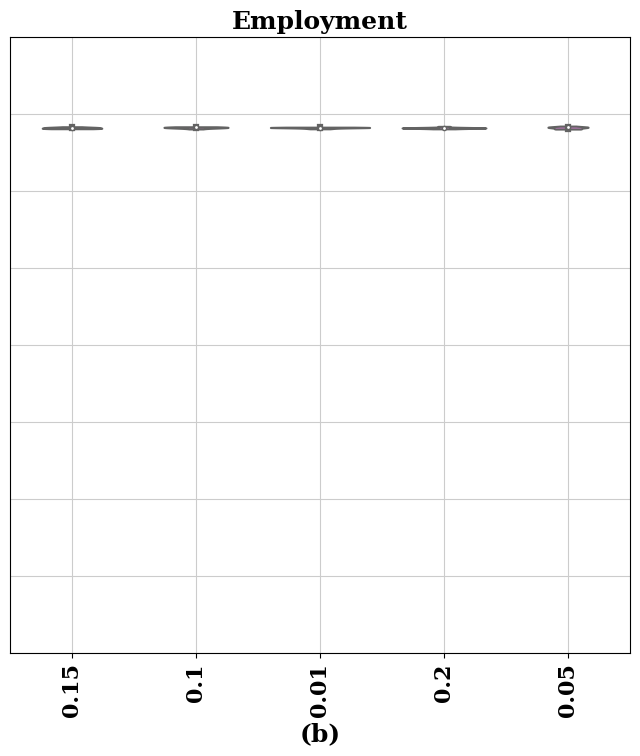

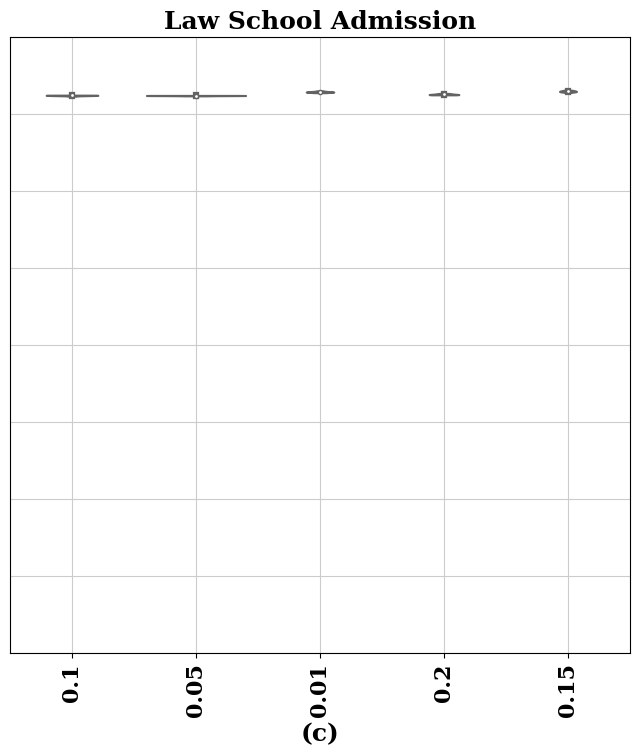

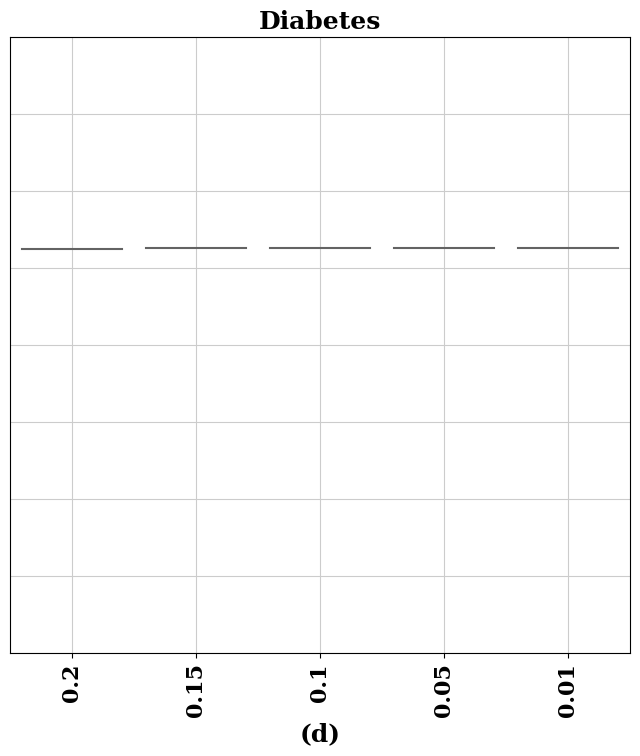

In [99]:
doplots('EGR','Accuracy','orchid')

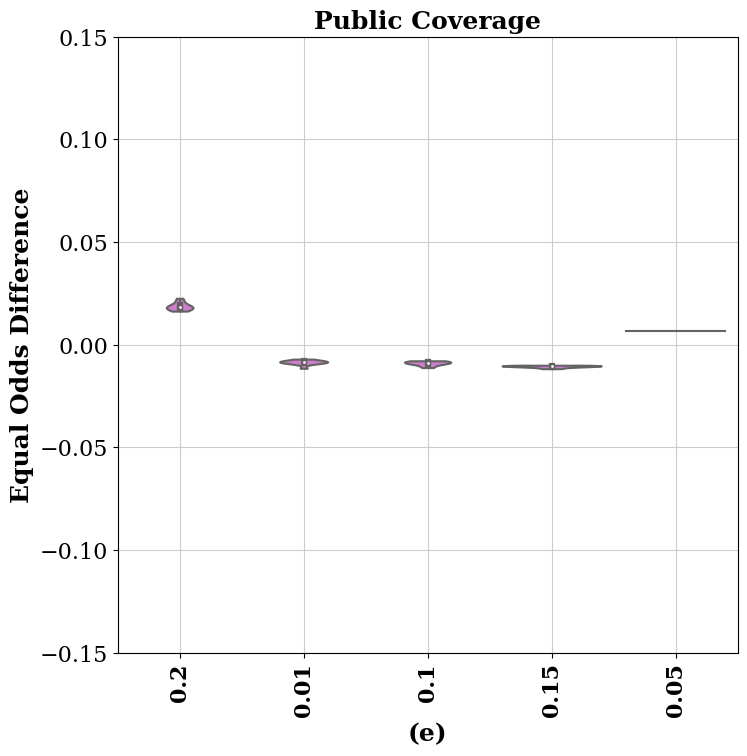

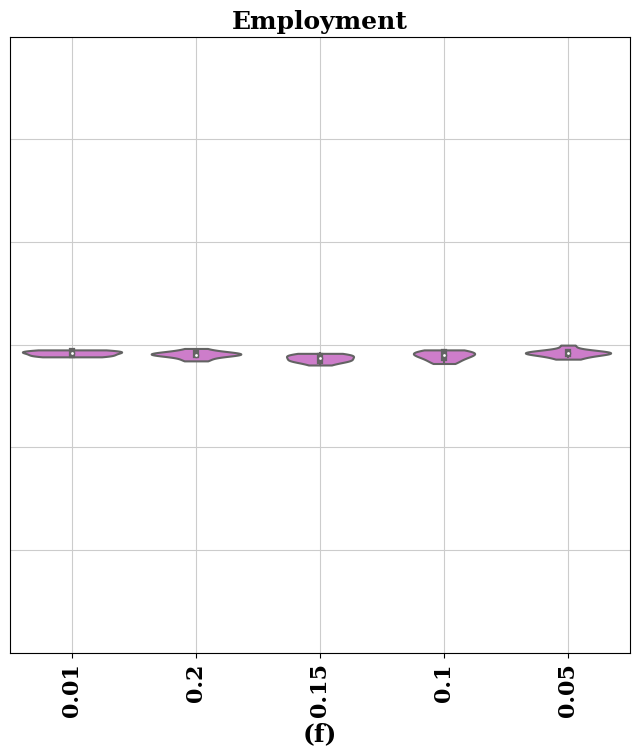

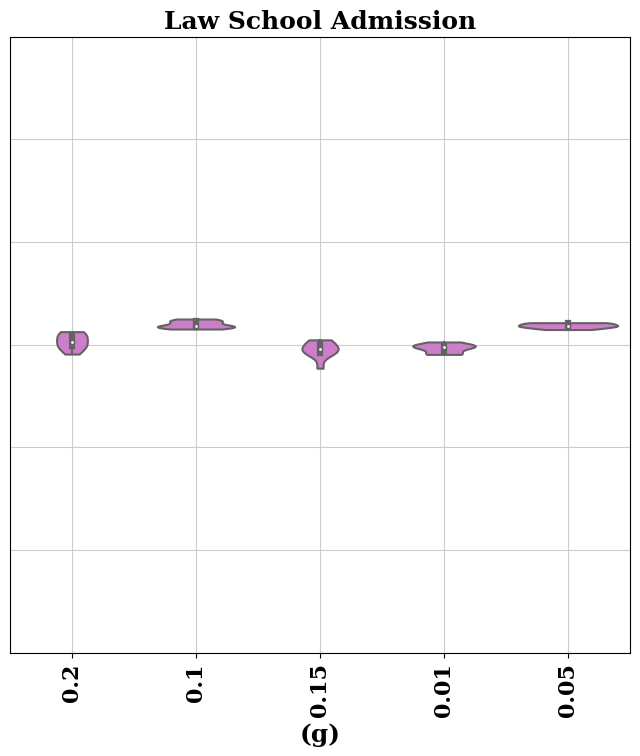

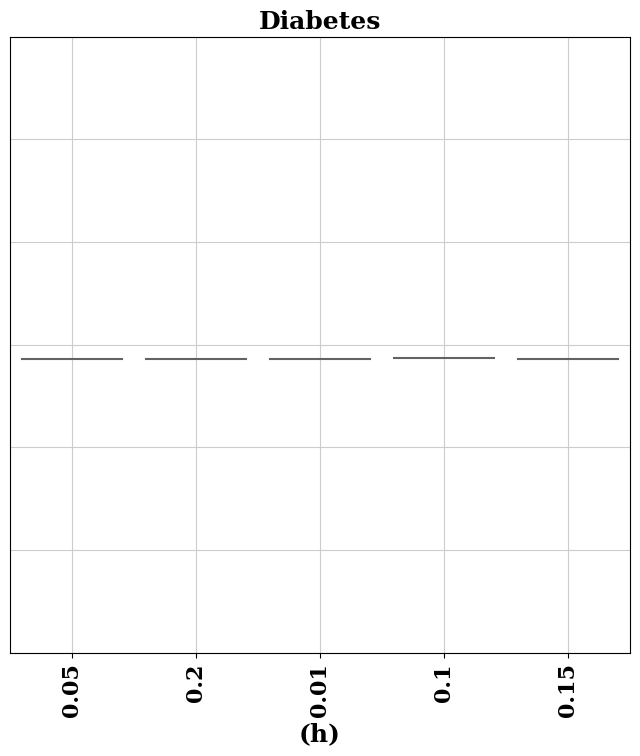

In [100]:
doplots('EGR','Equal Odds Difference','orchid')

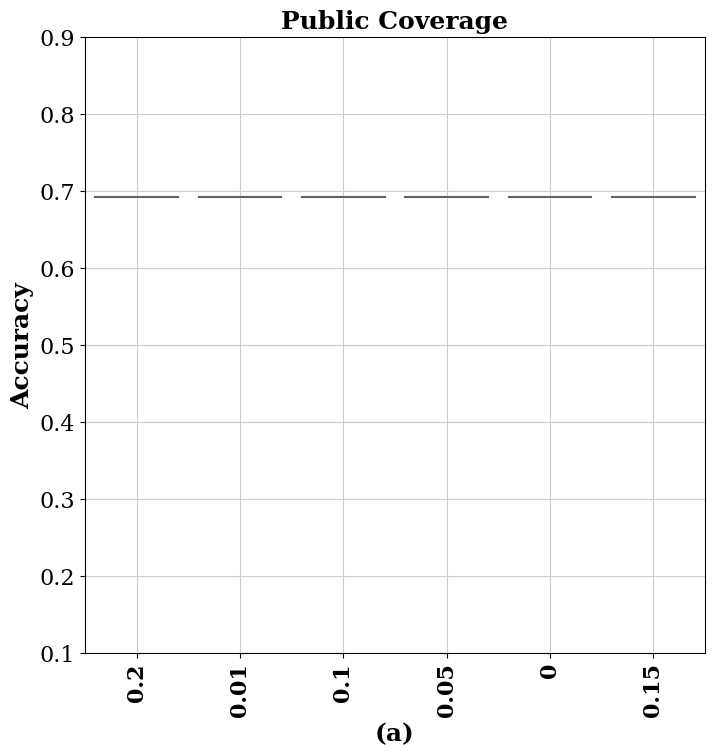

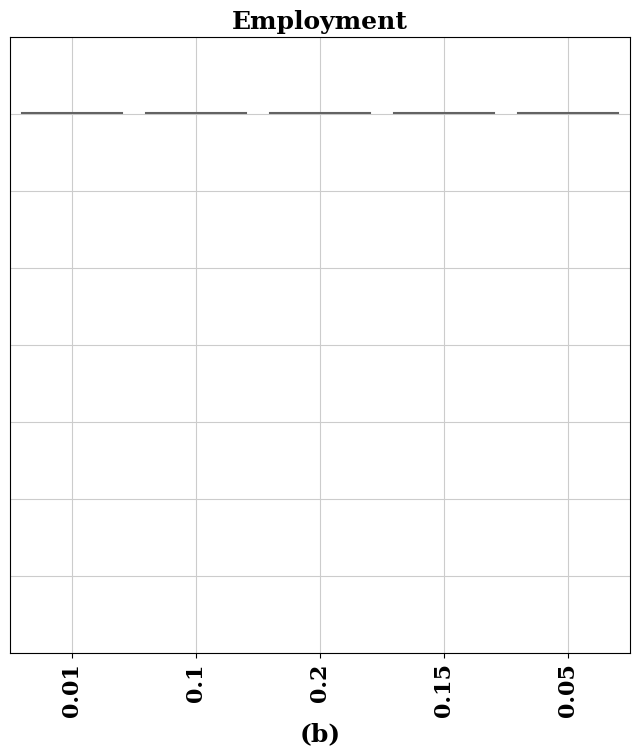

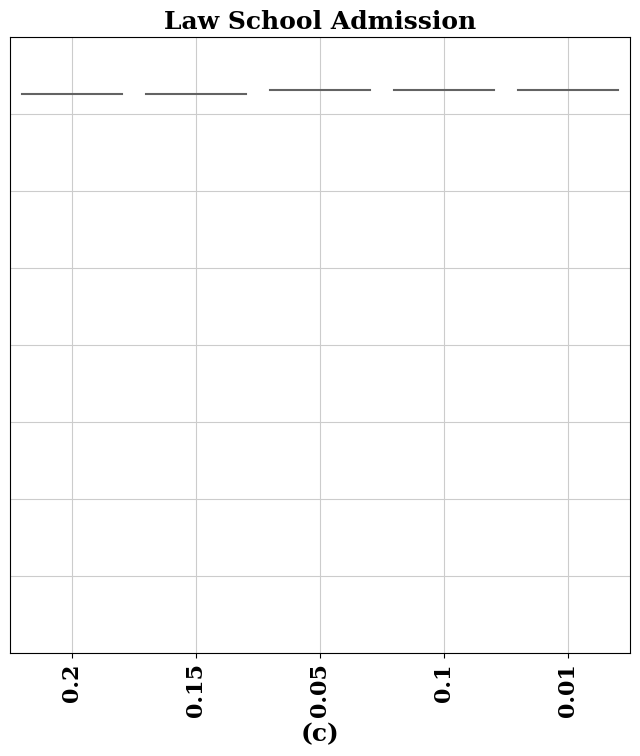

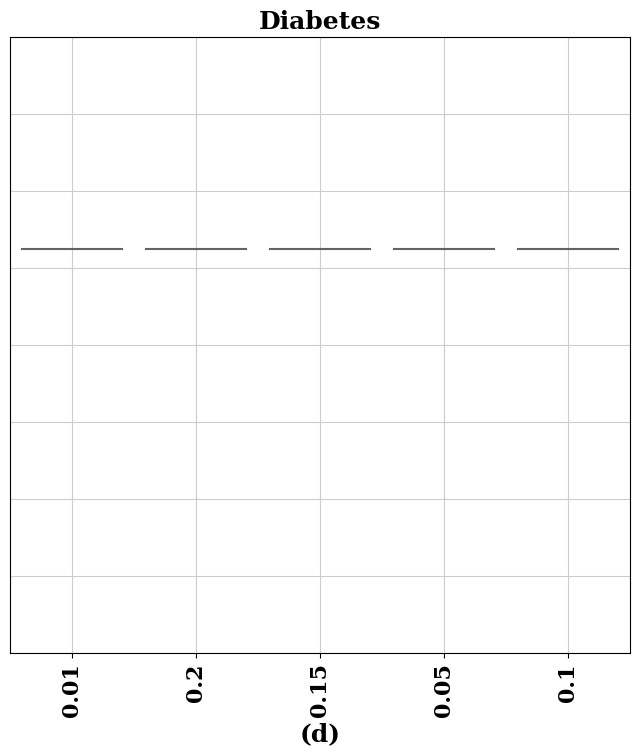

In [101]:
doplots('GSR','Accuracy','orchid')

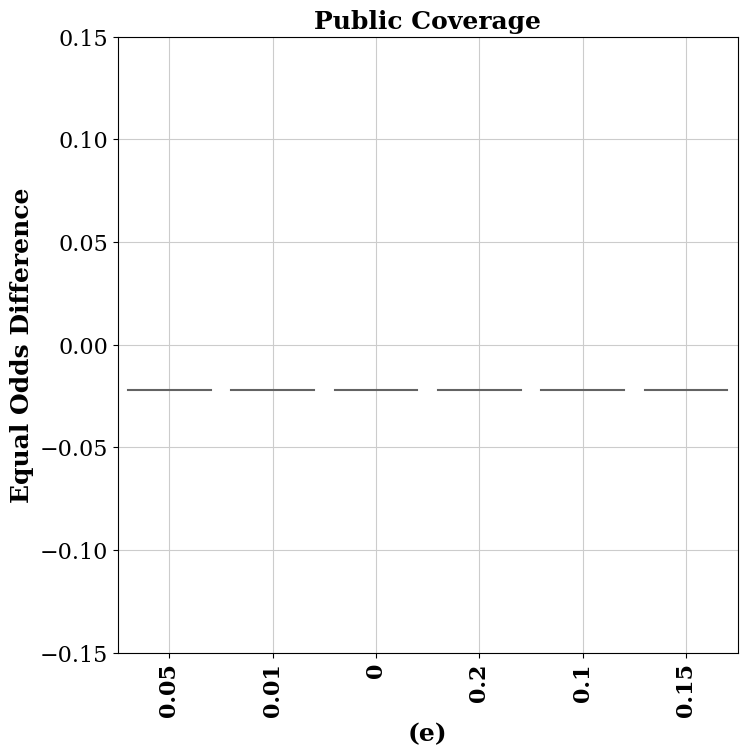

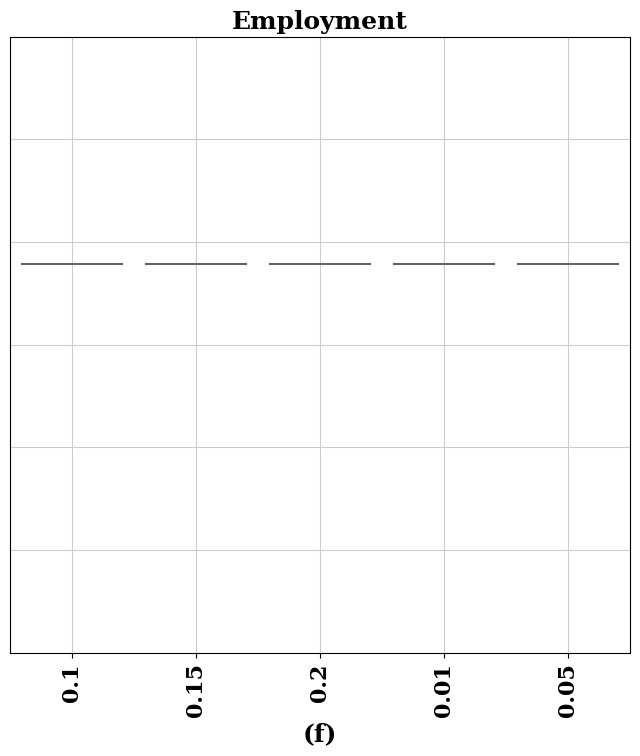

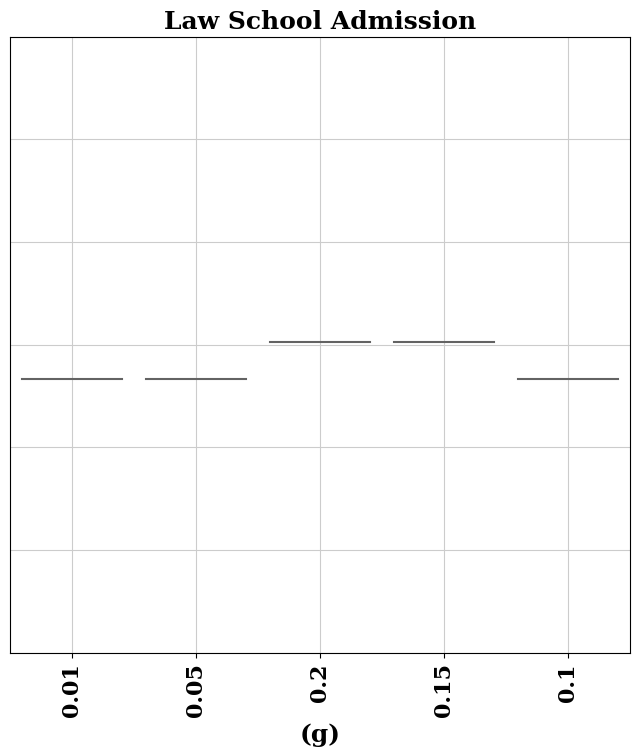

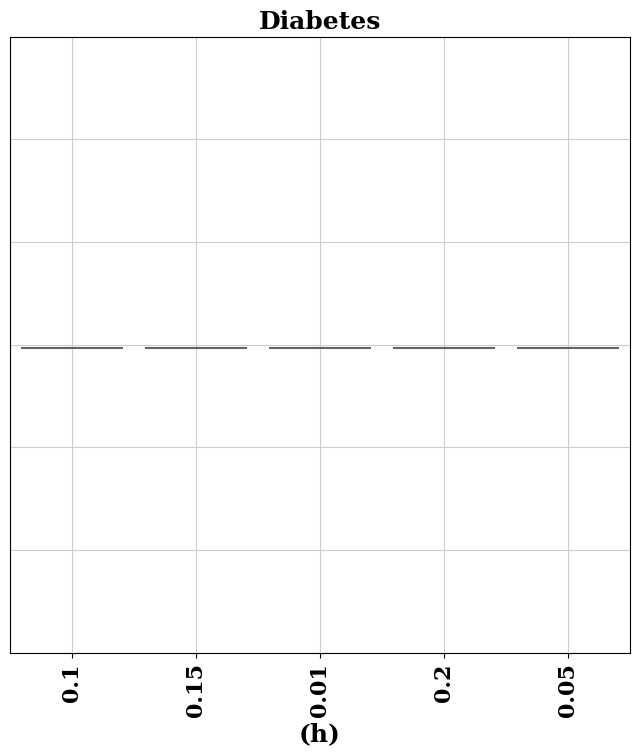

In [102]:
doplots('GSR','Equal Odds Difference','orchid')

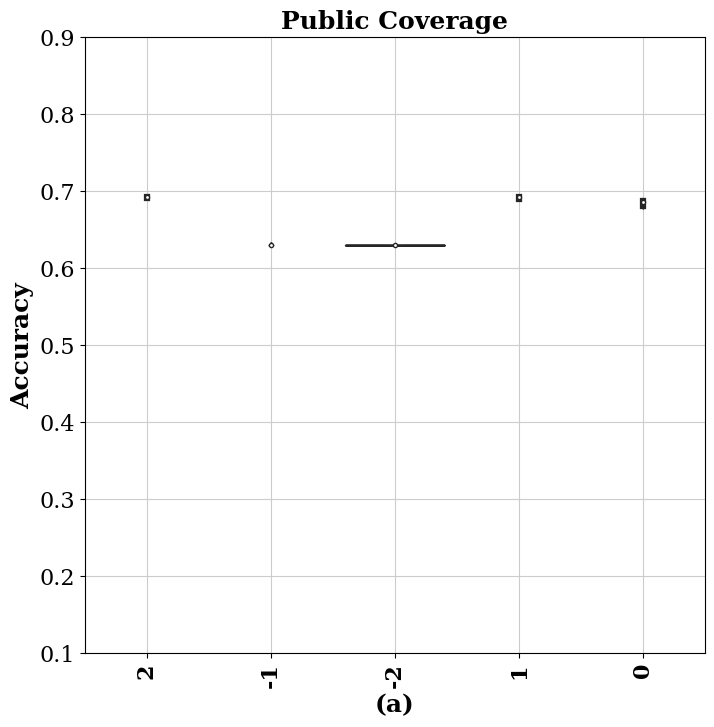

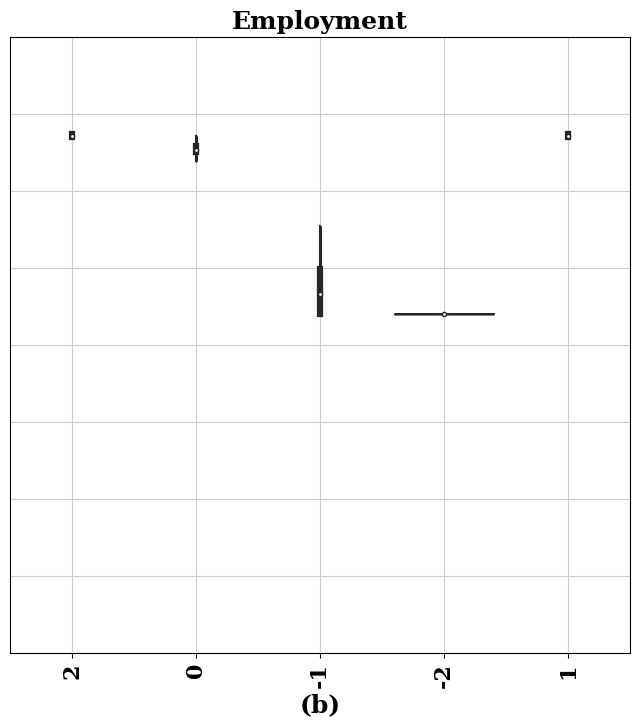

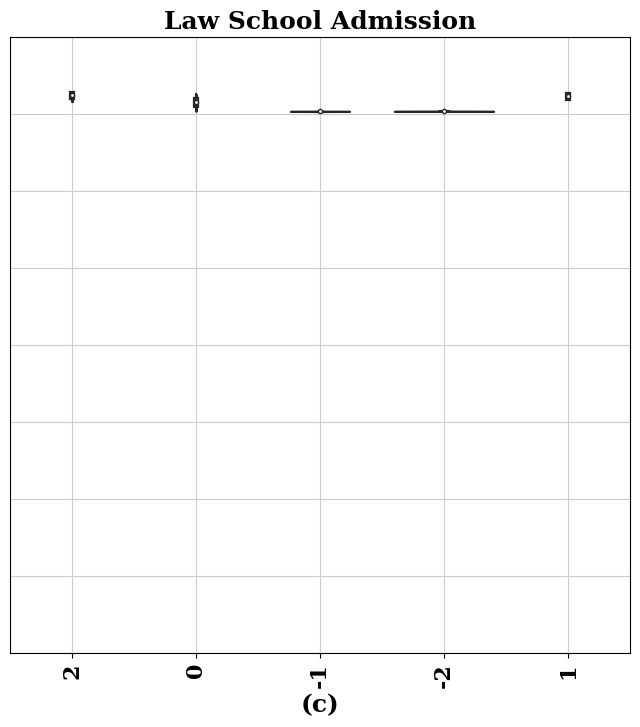

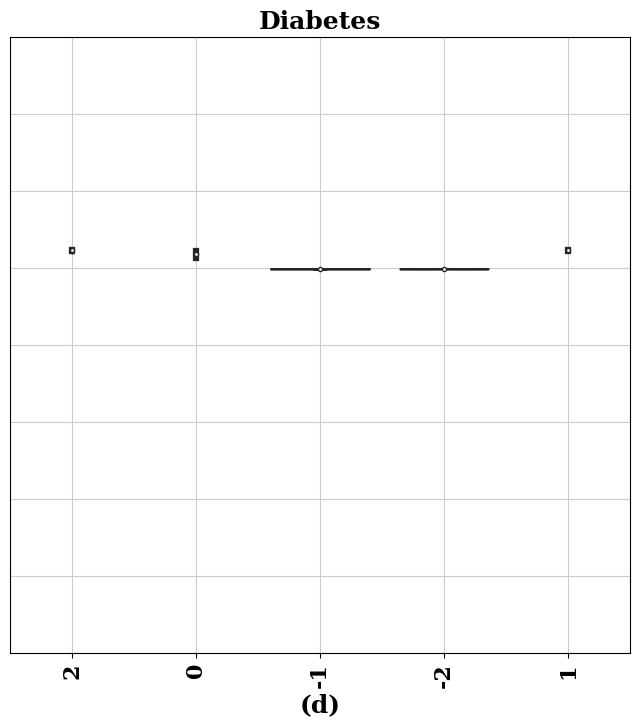

In [103]:
doplots('PRIV','Accuracy','green')

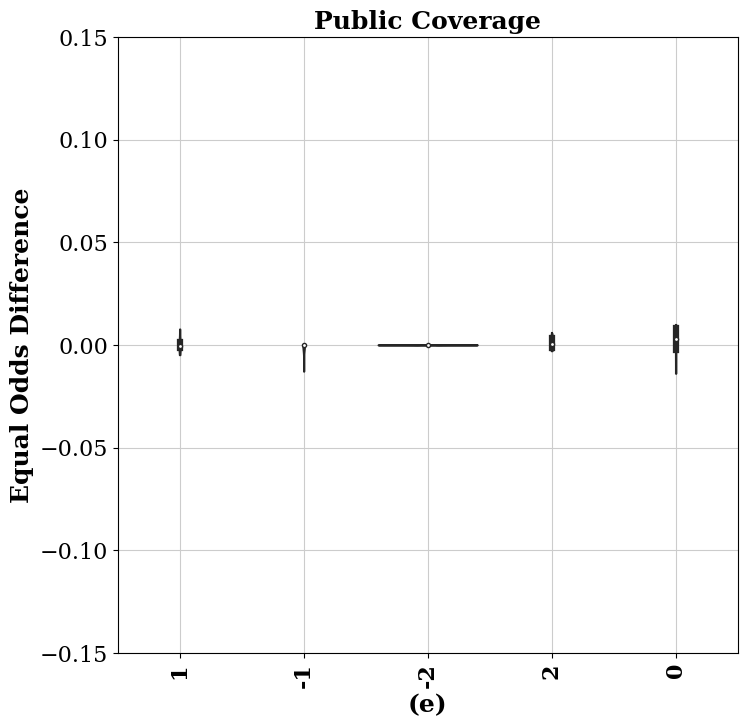

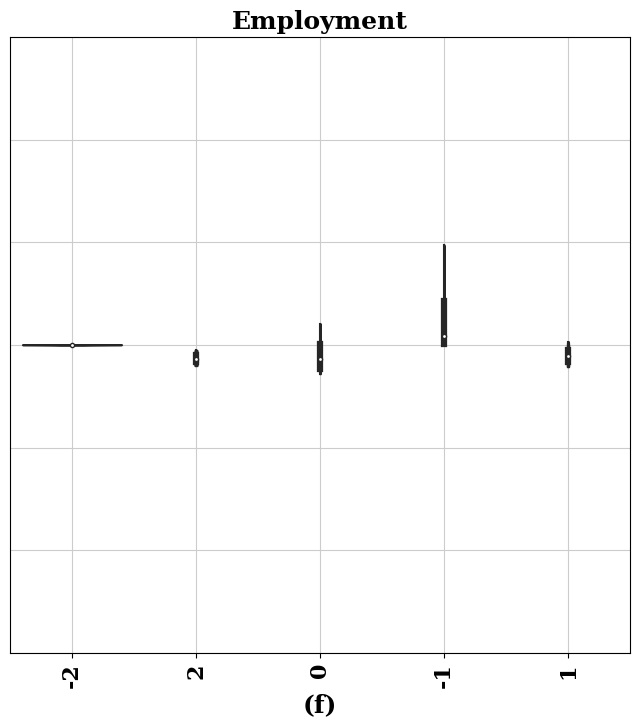

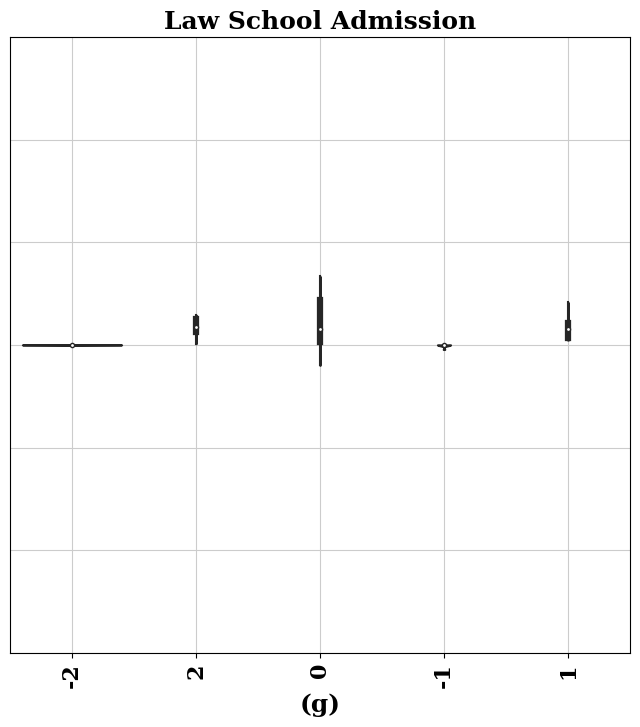

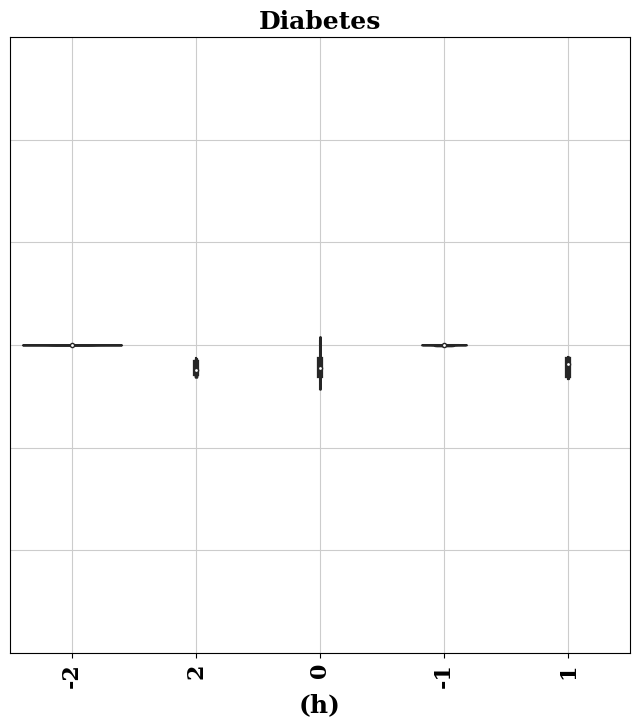

In [106]:
doplots('PRIV','Equal Odds Difference','green')

In [105]:
dfs[0]

,metric,algorithm,hyp,value,dataset
150,Accuracy,EGR,0.2,0.695644,Public Coverage
128,Accuracy,EGR,0.1,0.695680,Public Coverage
129,Accuracy,EGR,0.1,0.696294,Public Coverage
130,Accuracy,EGR,0.1,0.696113,Public Coverage
131,Accuracy,EGR,0.15,0.698387,Public Coverage
...,...,...,...,...,...
178,Equal Odds Difference,PRIV,-1,-0.000013,Public Coverage
177,Equal Odds Difference,PRIV,-1,0.000261,Public Coverage
176,Equal Odds Difference,PRIV,-1,-0.000133,Public Coverage
186,Equal Odds Difference,PRIV,0,0.000552,Public Coverage
